<a href="https://colab.research.google.com/github/stephennacion06/llm_engineering/blob/main/Copy_of_week_3_day_2_pipelines.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Welcome to Pipelines!

The HuggingFace transformers library provides APIs at two different levels.

The High Level API for using open-source models for typical inference tasks is called "pipelines". It's incredibly easy to use.

You create a pipeline using something like:

`my_pipeline = pipeline("the_task_I_want_to_do")`

Followed by

`result = my_pipeline(my_input)`

And that's it!

See end of this colab for a list of all pipelines.

## Before we start: 2 important pro-tips for using Colab:

**Pro-tip 1:**

Data Science code often gives warnings and messages. They can mostly be safely ignored! Glance over them, and if something goes wrong later, perhaps they can give you a clue.

**Pro-tip 2:**

In the middle of running a Colab, you might get an error like this:

> Runtime error: CUDA is required but not available for bitsandbytes. Please consider installing [...]

This is a super-misleading error message! Please don't try changing versions of packages...

This actually happens because Google has switched out your Colab runtime, perhaps because Google Colab was too busy. The solution is:

1. Kernel menu >> Disconnect and delete runtime
2. Reload the colab from fresh and Edit menu >> Clear All Outputs
3. Connect to a new T4 using the button at the top right
4. Select "View resources" from the menu on the top right to confirm you have a GPU
5. Rerun the cells in the colab, from the top down, starting with the pip installs

And all should work great - otherwise, ask me!


## A sidenote:

You may already know this, but just in case you're not familiar with the word "inference" that I use here:

When working with Data Science models, you could be carrying out 2 very different activities: **training** and **inference**.

### 1. Training  

**Training** is when you provide a model with data for it to adapt to get better at a task in the future. It does this by updating its internal settings - the parameters or weights of the model. If you're Training a model that's already had some training, the activity is called "fine-tuning".

### 2. Inference

**Inference** is when you are working with a model that has _already been trained_. You are using that model to produce new outputs on new inputs, taking advantage of everything it learned while it was being trained. Inference is also sometimes referred to as "Execution" or "Running a model".

All of our use of APIs for GPT, Claude and Gemini in the last weeks are examples of **inference**. The "P" in GPT stands for "Pre-trained", meaning that it has already been trained with data (lots of it!) In week 6 we will try fine-tuning GPT ourselves.
  
The pipelines API in HuggingFace is only for use for **inference** - running a model that has already been trained. In week 7 we will be training our own model, and we will need to use the more advanced HuggingFace APIs that we look at in the up-coming lecture.

I recorded this playlist on YouTube with more on parameters, training and inference:  
https://www.youtube.com/playlist?list=PLWHe-9GP9SMMdl6SLaovUQF2abiLGbMjs


In [ ]:
# Pip installs should come at the top line.
# If your Kernel ever resets, you need to run this again.

!pip install -q --upgrade datasets==3.6.0

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.5/491.5 kB 33.0 MB/s eta 0:00:00


In [ ]:
# Let's check the GPU - it should be a Tesla T4

gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)
  if gpu_info.find('Tesla T4') >= 0:
    print("Success - Connected to a T4")
  else:
    print("NOT CONNECTED TO A T4")

Thu Oct  9 04:31:49 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   53C    P8              9W /   70W |       0MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [ ]:
# Imports

import torch
from google.colab import userdata
from huggingface_hub import login
from transformers import pipeline
from diffusers import DiffusionPipeline
from datasets import load_dataset
import soundfile as sf
from IPython.display import Audio

# Important Note - Hugging Face account

In Day 1, we set up a FREE account on https://huggingface.co

### If you skipped this:

Please go back and do it! Then go to the Avatar menu, Tokens, and create an API token.. And make sure it has WRITE permissions! And then add it to the secrets on the left by pressing the key button.

### If you did this (thank you!)

Click on the Key button and turn on the switch so that this notebook gets access to your Hugging Face key.

In [ ]:
hf_token = userdata.get('HF_TOKEN')
if hf_token and hf_token.startswith("hf_"):
  print("HF key looks good so far")
else:
  print("HF key is not set - please click the key in the left sidebar")
login(hf_token, add_to_git_credential=True)

HF key looks good so far


## Using Pipelines from Hugging Face

A simple way to run inference for common tasks, without worrying about all the plumbing, picking reasonable defaults.


### How it works:

STEP 1: Create a pipeline - a function you can then call

```python
my_pipeline = pipeline(task, model=xx, device=xx)
```

If you don't specify a model, then Hugging Face picks one for you that's the default for the task. Specify "cuda" for the device to use an NVIDIA GPU like the one on the T4. Specify "mps" on a Mac.


STEP 2: Then call it as many times as you want:

```python
my_pipeline(input1)
my_pipeline(input2)
```

In [ ]:
# Sentiment Analysis

my_simple_sentiment_analyzer = pipeline("sentiment-analysis", device="cuda")
result = my_simple_sentiment_analyzer("I'm super excited to be on the way to LLM mastery!")
print(result)

No model was supplied, defaulted to distilbert/distilbert-base-uncased-finetuned-sst-2-english and revision 714eb0f (https://huggingface.co/distilbert/distilbert-base-uncased-finetuned-sst-2-english).
Using a pipeline without specifying a model name and revision in production is not recommended.
Device set to use cuda


[{'label': 'POSITIVE', 'score': 0.9993460774421692}]


In [ ]:
result = my_simple_sentiment_analyzer("I should be more excited to be on the way to LLM mastery!")
print(result)

[{'label': 'POSITIVE', 'score': 0.9008274674415588}]


In [ ]:

better_sentiment = pipeline("sentiment-analysis", model="nlptown/bert-base-multilingual-uncased-sentiment", device="cuda")
result = better_sentiment("I should be more excited to be on the way to LLM mastery!!")
print(result)

Device set to use cuda


[{'label': '3 stars', 'score': 0.39448031783103943}]


In [ ]:
# Named Entity Recognition

ner = pipeline("ner", device="cuda")
result = ner("AI Engineers are learning about the amazing pipelines from HuggingFace in Google Colab from Ed Donner")
for entity in result:
  print(entity)

No model was supplied, defaulted to dbmdz/bert-large-cased-finetuned-conll03-english and revision 4c53496 (https://huggingface.co/dbmdz/bert-large-cased-finetuned-conll03-english).
Using a pipeline without specifying a model name and revision in production is not recommended.
Some weights of the model checkpoint at dbmdz/bert-large-cased-finetuned-conll03-english were not used when initializing BertForTokenClassification: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Device set to use cuda


{'entity': 'I-ORG', 'score': np.float32(0.999476), 'index': 1, 'word': 'AI', 'start': 0, 'end': 2}
{'entity': 'I-ORG', 'score': np.float32(0.9962089), 'index': 2, 'word': 'Engineers', 'start': 3, 'end': 12}
{'entity': 'I-ORG', 'score': np.float32(0.8205678), 'index': 11, 'word': 'Hu', 'start': 59, 'end': 61}
{'entity': 'I-ORG', 'score': np.float32(0.651493), 'index': 12, 'word': '##gging', 'start': 61, 'end': 66}
{'entity': 'I-ORG', 'score': np.float32(0.960993), 'index': 13, 'word': '##F', 'start': 66, 'end': 67}
{'entity': 'I-ORG', 'score': np.float32(0.92517126), 'index': 14, 'word': '##ace', 'start': 67, 'end': 70}
{'entity': 'I-MISC', 'score': np.float32(0.8882749), 'index': 16, 'word': 'Google', 'start': 74, 'end': 80}
{'entity': 'I-MISC', 'score': np.float32(0.67307675), 'index': 17, 'word': 'Cola', 'start': 81, 'end': 85}
{'entity': 'I-PER', 'score': np.float32(0.9989441), 'index': 20, 'word': 'Ed', 'start': 92, 'end': 94}
{'entity': 'I-PER', 'score': np.float32(0.99872154), 'i

In [ ]:
# Question Answering with Context

question="What are Hugging Face pipelines?"
context="Pipelines are a high level API for inference of LLMs with common tasks"

question_answerer = pipeline("question-answering", device="cuda")
result = question_answerer(question=question, context=context)
print(result)

No model was supplied, defaulted to distilbert/distilbert-base-cased-distilled-squad and revision 564e9b5 (https://huggingface.co/distilbert/distilbert-base-cased-distilled-squad).
Using a pipeline without specifying a model name and revision in production is not recommended.
Device set to use cuda


{'score': 0.24576981365680695, 'start': 35, 'end': 70, 'answer': 'inference of LLMs with common tasks'}


In [ ]:
# Text Summarization

summarizer = pipeline("summarization", device="cuda")
text = """
The Hugging Face transformers library is an incredibly versatile and powerful tool for natural language processing (NLP).
It allows users to perform a wide range of tasks such as text classification, named entity recognition, and question answering, among others.
It's an extremely popular library that's widely used by the open-source data science community.
It lowers the barrier to entry into the field by providing Data Scientists with a productive, convenient way to work with transformer models.
"""
summary = summarizer(text, max_length=50, min_length=25, do_sample=False)
print(summary[0]['summary_text'])

No model was supplied, defaulted to sshleifer/distilbart-cnn-12-6 and revision a4f8f3e (https://huggingface.co/sshleifer/distilbart-cnn-12-6).
Using a pipeline without specifying a model name and revision in production is not recommended.
Device set to use cuda


 The Hugging Face transformers library is an incredibly versatile and powerful tool for natural language processing . It allows users to perform a wide range of tasks such as text classification, named entity recognition, and question answering .


In [ ]:
# Translation

translator = pipeline("translation_en_to_fr", device="cuda")
result = translator("The Data Scientists were truly amazed by the power and simplicity of the HuggingFace pipeline API.")
print(result[0]['translation_text'])

No model was supplied, defaulted to google-t5/t5-base and revision a9723ea (https://huggingface.co/google-t5/t5-base).
Using a pipeline without specifying a model name and revision in production is not recommended.
Device set to use cuda


Les Data Scientists ont été vraiment étonnés par la puissance et la simplicité de l'API du pipeline HuggingFace.


In [ ]:
# Another translation, showing a model being specified
# All translation models are here: https://huggingface.co/models?pipeline_tag=translation&sort=trending

translator = pipeline("translation_en_to_es", model="Helsinki-NLP/opus-mt-en-es", device="cuda")
result = translator("The Data Scientists were truly amazed by the power and simplicity of the HuggingFace pipeline API.")
print(result[0]['translation_text'])

/usr/local/lib/python3.12/dist-packages/transformers/models/marian/tokenization_marian.py:175: UserWarning: Recommended: pip install sacremoses.
  warnings.warn("Recommended: pip install sacremoses.")
Device set to use cuda


Los científicos de datos estaban verdaderamente sorprendidos por el poder y la simplicidad de la API de tuberías HuggingFace.


In [ ]:
# Classification

classifier = pipeline("zero-shot-classification", device="cuda")
result = classifier("Hugging Face's Transformers library is amazing!", candidate_labels=["technology", "sports", "politics"])
print(result)

No model was supplied, defaulted to facebook/bart-large-mnli and revision d7645e1 (https://huggingface.co/facebook/bart-large-mnli).
Using a pipeline without specifying a model name and revision in production is not recommended.
Device set to use cuda


{'sequence': "Hugging Face's Transformers library is amazing!", 'labels': ['technology', 'sports', 'politics'], 'scores': [0.9493839740753174, 0.03225007280707359, 0.018365919589996338]}


In [ ]:
# Text Generation

generator = pipeline("text-generation", device="cuda")
result = generator("If there's one thing I want you to remember about using HuggingFace pipelines, it's")
print(result[0]['generated_text'])

No model was supplied, defaulted to openai-community/gpt2 and revision 607a30d (https://huggingface.co/openai-community/gpt2).
Using a pipeline without specifying a model name and revision in production is not recommended.
Device set to use cuda
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


If there's one thing I want you to remember about using HuggingFace pipelines, it's that you don't need to be a programmer to understand how they work. The best way to learn about them is by simply using it for a few days.

However, there are some things you can do to learn the tools.

You can use the following command to add some of the following features into your Hugo list:

$ get-list -name "HuggingFace" -no-warnings -tag "show" -no-missing-features -no-warnings -tag "hide" -tag "huggingface" -tag "huggingface-plugin"

The best way to do this is to use something like:

$ get-list -name "HuggingFace" -no-warnings -tag "show" -no-missing-features -no-warnings -tag "hide" -tag "huggingface" -tag "huggingface-plugin"

How you can use the tools

How you can use the HuggingFace pipeline.

You can use any package and name your HuggingFace as the name of your plugin. This means you can use any tool (such as HuggingFace's own plugin, for example)


Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

`torch_dtype` is deprecated! Use `dtype` instead!


  0%|          | 0/4 [00:00<?, ?it/s]

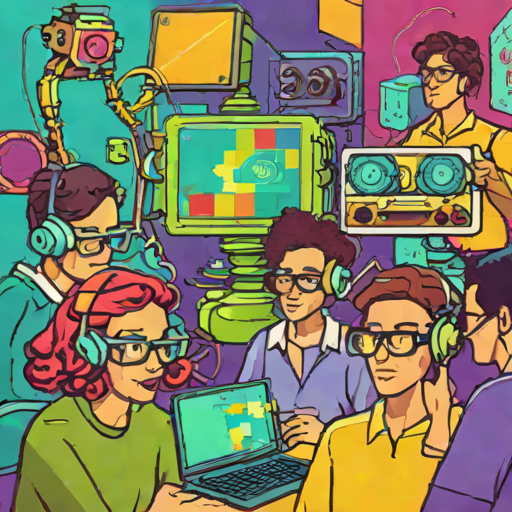

In [ ]:
# Image Generation - remember this?! Now you know what's going on
# Pipelines can be used for diffusion models as well as transformers

from IPython.display import display
from diffusers import AutoPipelineForText2Image
import torch

pipe = AutoPipelineForText2Image.from_pretrained("stabilityai/sdxl-turbo", torch_dtype=torch.float16, variant="fp16")
pipe.to("cuda")
prompt = "A class of students learning AI engineering in a vibrant pop-art style"
image = pipe(prompt=prompt, num_inference_steps=4, guidance_scale=0.0).images[0]
display(image)

In [ ]:
# Audio Generation

from transformers import pipeline
from datasets import load_dataset
import soundfile as sf
import torch
from IPython.display import Audio

synthesiser = pipeline("text-to-speech", "microsoft/speecht5_tts", device='cuda')
embeddings_dataset = load_dataset("matthijs/cmu-arctic-xvectors", split="validation", trust_remote_code=True)
speaker_embedding = torch.tensor(embeddings_dataset[7306]["xvector"]).unsqueeze(0)
speech = synthesiser("Hi to an artificial intelligence engineer, on the way to mastery!", forward_params={"speaker_embeddings": speaker_embedding})

Audio(speech["audio"], rate=speech["sampling_rate"])

Device set to use cuda


# All the available pipelines

Here are all the pipelines available from Transformers and Diffusers.

With thanks to student Lucky P for suggesting I include this!

There's a list pipelines under the Tasks on this page (you have to scroll down a bit, then expand the parameters to see the Tasks):

https://huggingface.co/docs/transformers/main_classes/pipelines

There's also this list of Tasks for Diffusion models instead of Transformers, following the image generation example where I use DiffusionPipeline above.

https://huggingface.co/docs/diffusers/en/api/pipelines/overview

If you come up with some cool examples of other pipelines, please share them with me! It's wonderful how HuggingFace makes this advanced AI functionality available for inference with such a simple API.